In [13]:
!pip install deepchem rdkit torch-geometric

In [14]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import deepchem as dc
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv, GATConv, EdgeConv, global_mean_pool, SAGPooling, GraphNorm
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import time

In [15]:
data = pd.read_csv('/kaggle/input/qm9-props/qm9_smiles_properties.csv') 
smiles_list = data['SMILES']
properties = data['G']

In [16]:
def smiles_to_graph(smiles, property_value):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    features = featurizer.featurize([smiles])
    if not features:
        return None

    atom_features = features[0].node_features
    edge_index = torch.tensor(features[0].edge_index, dtype=torch.long)
    edge_features = features[0].edge_features

    x = torch.tensor(atom_features, dtype=torch.float)
    y = torch.tensor([property_value], dtype=torch.float)
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

data_list = []
invalid_indices = []

for i, (smiles, prop) in enumerate(zip(smiles_list, properties)):
    data = smiles_to_graph(smiles, prop)
    if data is not None:
        data_list.append(data)
    else:
        invalid_indices.append(i)

print(f"Invalid SMILES indices: {invalid_indices}")

/tmp/ipykernel_31/2755395224.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not features:


Invalid SMILES indices: [0, 1, 2]


In [17]:
print(len(data_list))
print(len(smiles_list))

133882
133885


In [18]:
class GNN(torch.nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_dims=[128, 64], 
                 aggr='mean', attn_heads=4, use_attention=True, mlp_layers=[64, 128, 64, 1]):
        """
        Parameters:
        - node_feat_dim: int, Number of node features.
        - edge_feat_dim: int, Number of edge features.
        - hidden_dims: list, Hidden dimensions for each NNConv layer.
        - aggr: str, Aggregation type ('mean', 'sum', 'max').
        - attn_heads: int, Number of attention heads for GAT.
        - use_attention: bool, Whether to apply attention at the end of each layer.
        - mlp_layers: list, Fully connected MLP layers after pooling.
        """
        super(GNN, self).__init__()
        self.num_layers = len(hidden_dims)
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()
        self.edge_nns = torch.nn.ModuleList()
        self.attn_layers = torch.nn.ModuleList()
        
        prev_dim = node_feat_dim
        for i, h_dim in enumerate(hidden_dims):
            # Define the edge network to transform edge features
            edge_nn = Sequential(
                Linear(edge_feat_dim, h_dim),
                ReLU(),
                Linear(h_dim, prev_dim * h_dim)  # output dimensionality will be prev_dim * h_dim
            )
            self.edge_nns.append(edge_nn)
            
            # Define the NNConv layer, passing the edge_nn as the transformation function
            edge_conv = NNConv(in_channels=prev_dim, out_channels=h_dim, 
                               nn=edge_nn, aggr=aggr)
            self.convs.append(edge_conv)
            
            # GraphNorm for normalizing the node features
            self.norms.append(GraphNorm(h_dim))
            
            # Add attention layers if required
            if use_attention:
                self.attn_layers.append(GATConv(h_dim, h_dim // attn_heads, heads=attn_heads, concat=True))
          
            prev_dim = h_dim
        
        # Define the MLP layers after pooling
        mlp_layers_seq = []
        for i in range(len(mlp_layers) - 1):
            mlp_layers_seq.append(Linear(mlp_layers[i], mlp_layers[i + 1]))
            if i < len(mlp_layers) - 2:
                mlp_layers_seq.append(ReLU())
        
        self.mlp = Sequential(*mlp_layers_seq)
    
    def forward(self, x, edge_index, edge_attr=None, batch=None):
        for i, (conv, norm) in enumerate(zip(self.convs, self.norms)):
            x = conv(x, edge_index, edge_attr).relu()
            x = norm(x)
            if len(self.attn_layers) > i:
                x = self.attn_layers[i](x, edge_index).relu()

        x = global_mean_pool(x, batch)
        return self.mlp(x)

In [19]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs, max_allowed_increases=5):
    consecutive_increase_counter = 0
    prev_val_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            outputs = model(
                batch.x,
                batch.edge_index,
                batch.edge_attr,
                batch.batch
            ).squeeze(-1)

            loss = criterion(outputs, batch.y.to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                
                outputs = model(
                    batch.x,
                    batch.edge_index,
                    batch.edge_attr,
                    batch.batch
                ).squeeze(-1)

                loss = criterion(outputs, batch.y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss > prev_val_loss:
            consecutive_increase_counter += 1
        else:
            consecutive_increase_counter = 0

        prev_val_loss = avg_val_loss

        if consecutive_increase_counter >= max_allowed_increases:
            print(f"Early stopping triggered after {max_allowed_increases} consecutive increases in validation loss!")
            break

    return train_losses, val_losses

In [20]:
def evaluate_model(model, test_loader, device):
    model.eval()
    actual_values = []
    predicted_values = []

    start_time = time.time()
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            properties = batch.y
            outputs = model(
                batch.x,
                batch.edge_index,
                batch.edge_attr,
                batch.batch
            ).squeeze(-1)
            actual_values.extend(properties.cpu().numpy())
            predicted_values.extend(outputs.cpu().numpy())
    end_time = time.time()

    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    mse = mean_squared_error(actual_values, predicted_values)
    mae = mean_absolute_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)
    inference_time = (end_time - start_time) / len(test_loader)
    
    print(f"Inference time per 1000 samples: {inference_time*1000:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.6, label="Predictions")
    plt.plot(
        [min(actual_values), max(actual_values)],
        [min(actual_values), max(actual_values)],
        color="red",
        linestyle="--",
        label="Ideal Fit"
    )
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.legend()
    plt.grid()
    plt.show()

In [21]:
def run_pipeline(model, data_list, epochs, train_size, batch_size=32):
    train_data, test_data = train_test_split(data_list, test_size=(1 - train_size), random_state=42)
    val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()

    train_losses, val_losses = train_model(
        model, train_loader, val_loader, optimizer, criterion, device, epochs
    )

    plt.plot(train_losses[1:], label='Train Loss')
    plt.plot(val_losses[1:], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    evaluate_model(model, test_loader, device)

Epoch [1/100], Train Loss: 3213.7348, Validation Loss: 572.7375
Epoch [2/100], Train Loss: 549.3157, Validation Loss: 546.8339
Epoch [3/100], Train Loss: 463.8555, Validation Loss: 410.4633
Epoch [4/100], Train Loss: 389.0906, Validation Loss: 364.4642
Epoch [5/100], Train Loss: 328.8657, Validation Loss: 289.4214
Epoch [6/100], Train Loss: 277.0438, Validation Loss: 357.3935
Epoch [7/100], Train Loss: 241.2478, Validation Loss: 239.6739
Epoch [8/100], Train Loss: 219.7299, Validation Loss: 224.6351
Epoch [9/100], Train Loss: 195.2660, Validation Loss: 172.4880
Epoch [10/100], Train Loss: 175.8417, Validation Loss: 150.9356
Epoch [11/100], Train Loss: 161.2102, Validation Loss: 140.9589
Epoch [12/100], Train Loss: 145.8915, Validation Loss: 127.7992
Epoch [13/100], Train Loss: 134.4107, Validation Loss: 153.2831
Epoch [14/100], Train Loss: 128.8864, Validation Loss: 116.1883
Epoch [15/100], Train Loss: 121.3411, Validation Loss: 112.9654
Epoch [16/100], Train Loss: 113.2511, Validation

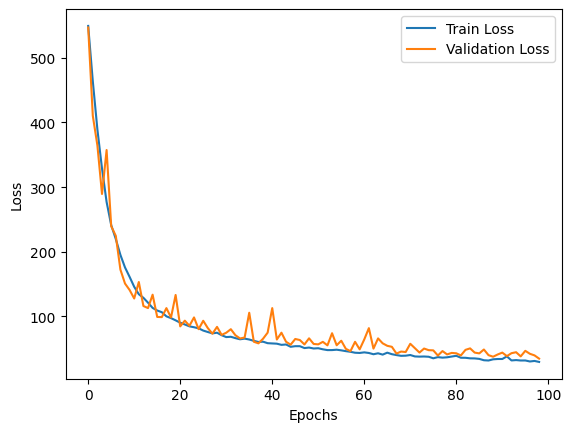

Inference time per 1000 samples: 5.9787
Mean Squared Error (MSE): 30.1289
Mean Absolute Error (MAE): 3.3658
R-Squared (R²): 0.9808


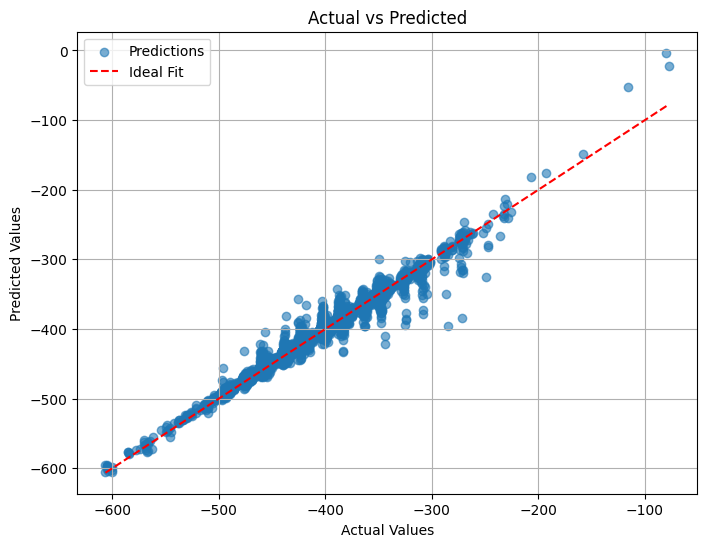

In [79]:
model = GNN(node_feat_dim=30, edge_feat_dim=11, hidden_dims=[128, 64], attn_heads=4, use_attention=True)
run_pipeline(model, data_list, epochs=100, train_size=0.75)

torch.save(model.state_dict(), "gnn_2ly_4att_75data_model.pth")

In [80]:
import networkx as nx

from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.utils import to_networkx

from rdkit import Chem
from rdkit.Chem import Draw

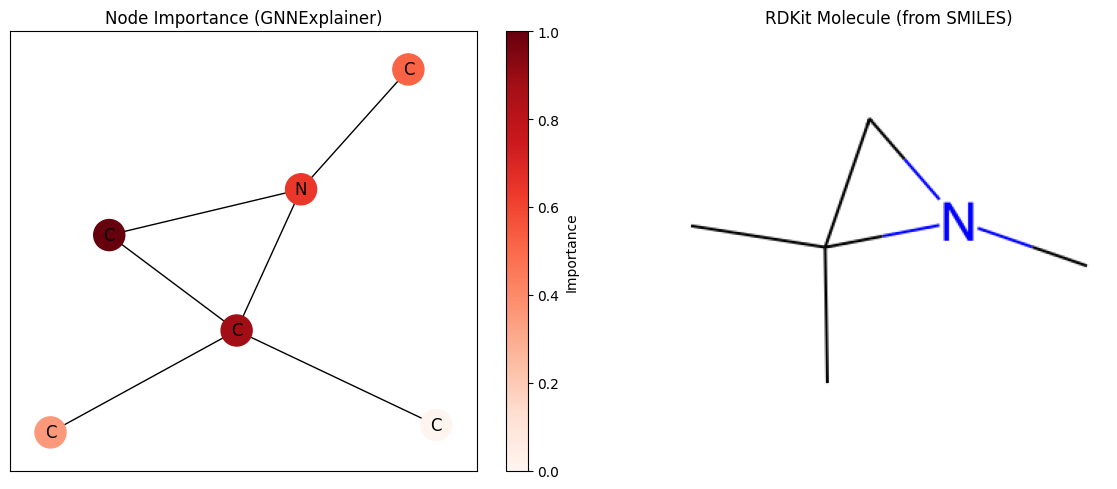

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_index = 300
sample_graph = data_list[sample_index].to(device)

atom_symbol_list = ["C", "N", "O", "F", "P", "S", "Cl", "Br", "I", "Other"]

model.eval()

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=300),
    explanation_type='model',
    node_mask_type='object',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
)

explanation = explainer(
    x=sample_graph.x,
    edge_index=sample_graph.edge_index,
    edge_attr=sample_graph.edge_attr,
    batch=sample_graph.batch,
)

# Node importance
node_mask = explanation.node_mask.cpu().detach().numpy()
node_importance = (node_mask - node_mask.min()) / (node_mask.max() - node_mask.min() + 1e-6)
node_colors = plt.cm.Reds(node_importance)

one_hot_vectors = sample_graph.x[:, :10].cpu().numpy()
atom_type_indices = np.argmax(one_hot_vectors, axis=1)
atom_labels = [atom_symbol_list[i] for i in atom_type_indices]

G = to_networkx(sample_graph.cpu(), to_undirected=True)
pos = nx.spring_layout(G, seed=42)

# Plot node importance and RDKit molecule image
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Node importance plot
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, ax=axs[0])
nx.draw_networkx_edges(G, pos, ax=axs[0])
nx.draw_networkx_labels(G, pos, labels={i: label for i, label in enumerate(atom_labels)}, ax=axs[0])
axs[0].set_title("Node Importance (GNNExplainer)")
sm1 = plt.cm.ScalarMappable(cmap='Reds')
plt.colorbar(sm1, ax=axs[0], label='Importance')

# RDKit molecule image
mol = Chem.MolFromSmiles(smiles_list[sample_index+3])
img = Draw.MolToImage(mol, size=(300, 300))
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title("RDKit Molecule (from SMILES)")

plt.tight_layout()
plt.show()

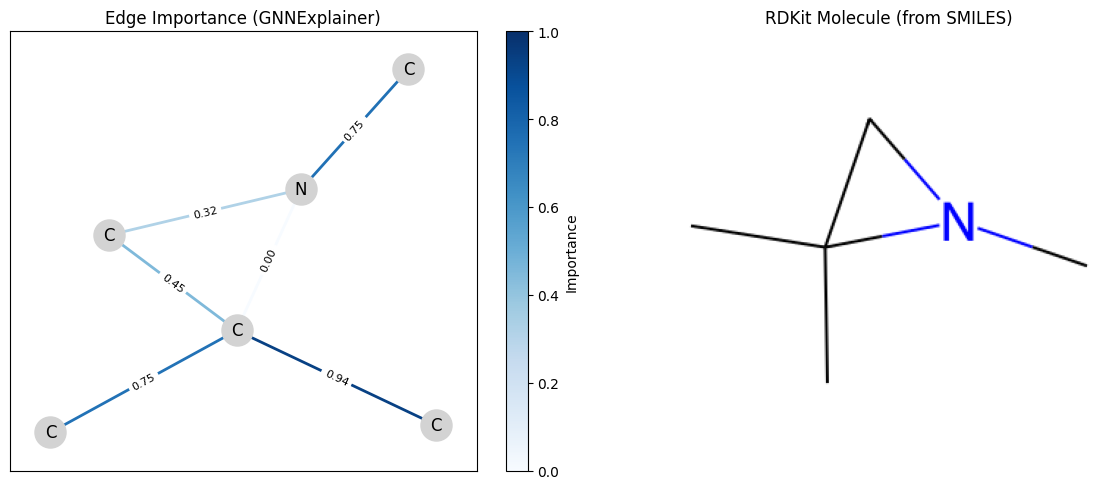

In [99]:
# Edge importance
edge_mask = explanation.edge_mask.cpu().detach().numpy()
edge_importance = (edge_mask - edge_mask.min()) / (edge_mask.max() - edge_mask.min() + 1e-6)
edge_colors = [plt.cm.Blues(val) for val in edge_importance]

edge_tuples = list(G.edges())
edge_labels = {edge_tuples[i]: f"{edge_importance[i]:.2f}" for i in range(len(edge_tuples))}

# Plot edge importance and RDKit molecule image
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Edge importance plot
nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=500, ax=axs[0])
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2, ax=axs[0])
nx.draw_networkx_labels(G, pos, labels={i: label for i, label in enumerate(atom_labels)}, ax=axs[0])
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=axs[0])
axs[0].set_title("Edge Importance (GNNExplainer)")
sm2 = plt.cm.ScalarMappable(cmap='Blues')
plt.colorbar(sm2, ax=axs[0], label='Importance')

# RDKit molecule image
mol = Chem.MolFromSmiles(smiles_list[sample_index+3])
img = Draw.MolToImage(mol, size=(300, 300))
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title("RDKit Molecule (from SMILES)")

plt.tight_layout()
plt.show()